### Simple Game of Life

In [1]:
%useLatestDescriptors
%use multik, lib-ext

Utility functions to implement a game field based on multik arrays

In [2]:
fun MultiArray<Byte, D2>.alive(x: Int, y: Int) = this[y, x] > 0
fun MultiArray<Byte, D2>.alive(coordinates: Pair<Int, Int>) = alive(coordinates.first, coordinates.second)
fun MutableMultiArray<Byte, D2>.setAlive(x: Int, y: Int, value: Boolean = true) {
    this[y, x] = if (value) 1 else 0
}

fun MultiIndexProgression.toIterable(): Iterable<IntArray> {
    return object : Iterable<IntArray> {
        override fun iterator(): Iterator<IntArray> {
            return this@toIterable.iterator()
        }
    }
}

fun neighborIndices(x: Int, y: Int, shape: IntArray): Iterable<Pair<Int, Int>> {
    val progression = intArrayOf(y - 1, x - 1)..intArrayOf(y + 1, x + 1)
    return progression.toIterable().map {
        intArrayOf(it[0].mod(shape[0]), it[1].mod(shape[1]))
    }.map { it[1] to it[0] }.filter { it != x to y }
}

fun MultiArray<Byte, D2>.next(x: Int, y: Int): Boolean {
    val slices = neighborIndices(x, y, shape)
    val map = slices.map { alive(it) }
    val aliveNeighbors = map.count { it }
    if (alive(x, y)) {
        return (aliveNeighbors == 2 || aliveNeighbors == 3)
    }
    return aliveNeighbors == 3
}

Game field class

In [3]:
import kotlin.random.Random

class Field(initialState: D2Array<Byte>) {
    private var pointer = 0
    private val buffers: D3Array<Byte> = mk.stack(initialState, mk.zeros(initialState.shape, initialState.dtype))
    val width: Int = buffers.shape[2]
    val height: Int = buffers.shape[1]

    constructor(width: Int, height: Int) : this(mk.zeros<Byte>(height, width))

    private val _field: MutableMultiArray<Byte, D2> get() = buffers.writableView(pointer, axis = 0)
    val field: MultiArray<Byte, D2> get() = _field

    fun alive(x: Int, y: Int) = field.alive(x, y)

    fun step() {
        val nextField: MutableMultiArray<Byte, D2> = buffers.writableView(1 - pointer, axis = 0)
        for (i in 0 until width) {
            for (j in 0 until height) {
                nextField.setAlive(i, j, field.next(i, j))
            }
        }

        pointer = 1 - pointer
    }

    fun randomize() {
        for (i in 0 until width) {
            for (j in 0 until height) {
                _field.setAlive(i, j, Random.nextBoolean())
            }
        }
    }

    override fun toString() = field.toString()
}

Test on a blinker

In [4]:
val field5x5 = Field(mk.zeros<Byte>(5, 5).also {
    it.setAlive(1, 2)
    it.setAlive(2, 2)
    it.setAlive(3, 2)
})
repeat(3) {
    DISPLAY(field5x5)
    field5x5.step()
}

[[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0],
[0, 1, 1, 1, 0],
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0]]

[[0, 0, 0, 0, 0],
[0, 0, 1, 0, 0],
[0, 0, 1, 0, 0],
[0, 0, 1, 0, 0],
[0, 0, 0, 0, 0]]

[[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0],
[0, 1, 1, 1, 0],
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0]]

Utility function to draw a field

In [5]:
import java.awt.Color
import java.awt.image.BufferedImage

fun Field.draw(
    scale: Int, foreground: Color = Color(60, 101, 171),
    background: Color = Color(28, 28, 28)
): BufferedImage {
    val image = BufferedImage(scale * width, scale * height, BufferedImage.TYPE_INT_RGB)
    val graphics2D = image.createGraphics()

    graphics2D.color = background
    graphics2D.fillRect(0, 0, width * scale, height * scale)

    graphics2D.color = foreground
    for (i in 0 until width) {
        for (j in 0 until height) {
            if (alive(i, j)) {
                graphics2D.fillRect(i * scale, j * scale, scale, scale)
            }
        }
    }
    graphics2D.dispose()
    return image
}

Create the game field, update and draw it in a loop. Does not work in the IDE.

In [6]:
val gameField = Field(100, 100)
gameField.randomize()


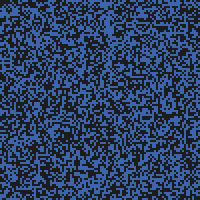

The execution was interrupted

In [ ]:
import org.jetbrains.kotlinx.jupyter.ext.Image
import java.util.UUID

val imageId = UUID.randomUUID().toString()
DISPLAY(Image(gameField.draw(2)), imageId)

while (true) {
    Thread.sleep(1000)
    gameField.step()
    UPDATE_DISPLAY(gameField.draw(2), imageId)
}

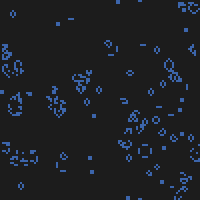

In [8]:
gameField.draw(2)